# Bayesian optimization with `skopt`

Gilles Louppe, July 2016.

In [1]:
import numpy as np
np.random.seed(777)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

## Problem statement

We are interested in solving $$x^* = \arg \min_x f(x)$$ under the constraints that

- $f$ is a black box for which no closed form is known (nor its gradients);
- $f$ is expensive to evaluate;
- evaluations $y = f(x)$ of may be noisy.

**Disclaimer.** If you do not have these constraints, then there is certainly a better optimization algorithm than Bayesian optimization.

## Bayesian optimization loop

For $t=1:T$:

1. Given observations $(x_i, y_i=f(x_i))$ for $i=1:t$, build a probabilistic model for the objective $f$. Integrate out all possible true functions, using Gaussian process regression.
   
2. optimize a cheap acquisition/utility function $u$ based on the posterior distribution for sampling the next point.
   $$x_{t+1} = \arg \min_x u(x)$$
   Exploit uncertainty to balance exploration against exploitation.
    
3. Sample the next observation $y_{t+1}$ at $x_{t+1}$.

## Acquisition functions

Acquisition functions $\text{u}(x)$ specify which sample $x$ should be tried next:

- Lower confidence bound: $\text{LCB}(x) = \mu_{GP}(x) + \kappa \sigma_{GP}(x)$;
- Probability of improvement: $-\text{PI}(x) = -P(f(x) \geq f(x_t^+) + \kappa) $;
- Expected improvement: $-\text{EI}(x) = -\mathbb{E} [f(x) - f(x_t^+)] $;

where $x_t^+$ is the best point observed so far.

In most cases, acquisition functions provide knobs (e.g., $\kappa$) for
controlling the exploration-exploitation trade-off.
- Search in regions where $\mu_{GP}(x)$ is high (exploitation)
- Probe regions where uncertainty $\sigma_{GP}(x)$ is high (exploration)

## Toy example

Let assume the following noisy function $f$:

In [2]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

**Note.** In `skopt`, functions $f$ are assumed to take as input a 1D vector $x$ represented as an array-like and to return a scalar $f(x)$.

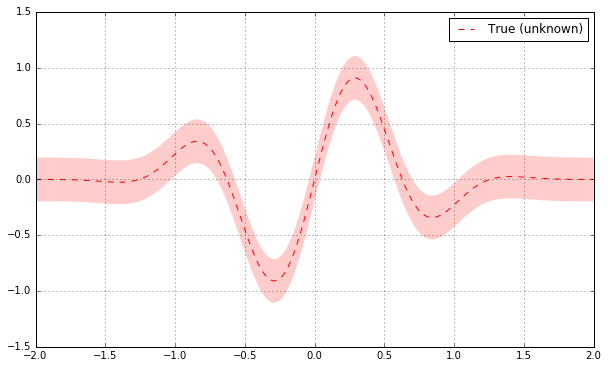

In [3]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

Bayesian optimization based on gaussian process regression is implemented in `skopt.gp_minimize` and can be carried out as follows:

In [4]:
from skopt import gp_minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

gp = GaussianProcessRegressor(kernel=Matern(length_scale_bounds="fixed"), 
                              alpha=noise_level**2, random_state=0)

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq="LCB",          # the acquisition function (optional)
                  base_estimator=gp,  # a GP estimator (optional)
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=1,  # the number of random evaluations at initialization
                  random_state=777)

Accordingly, the approximated minimum is found to be:

In [5]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.2950, f(x^*)=-0.9909'

For further inspection of the results, attributes of the `res` named tuple provide the following information:

- `x` [float]: location of the minimum.
- `fun` [float]: function value at the minimum.
- `models`: surrogate models used for each iteration.
- `x_iters` [array]: location of function evaluation for each
   iteration.
- `func_vals` [array]: function value for each iteration.
- `space` [Space]: the optimization space.

In [6]:
res

       fun: -0.99086677726910888
 func_vals: array([ 0.19928047,  0.05426552,  0.73707278, -0.09170696,  0.0205681 ,
       -0.0143208 ,  0.3971182 ,  0.10637845, -0.11715768, -0.99086678,
       -0.81299046, -0.70832964, -0.88766165, -0.89399144, -0.72523841])
    models: [GaussianProcessRegressor(alpha=0.010000000000000002, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=1.5), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b', random_state=0), GaussianProcessRegressor(alpha=0.010000000000000002, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=1.5), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b', random_state=0), GaussianProcessRegressor(alpha=0.010000000000000002, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=1.5), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b', random_state=0), GaussianProcessRegressor(alpha=0.010000000000000002, 

Together these attributes can be used to visually inspect the results of the minimization, such as the convergence trace or the acquisition function at the last iteration:

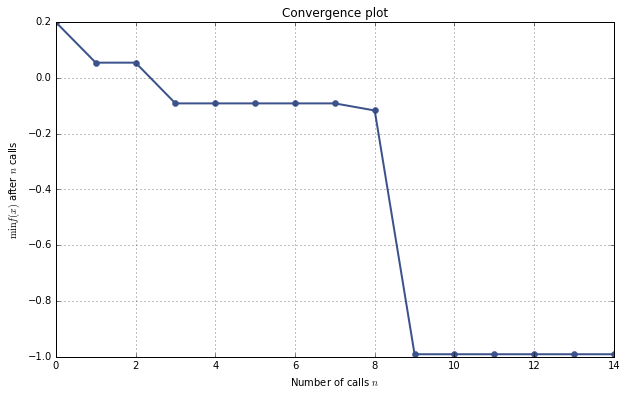

In [7]:
from skopt.plots import plot_convergence
plot_convergence(res)

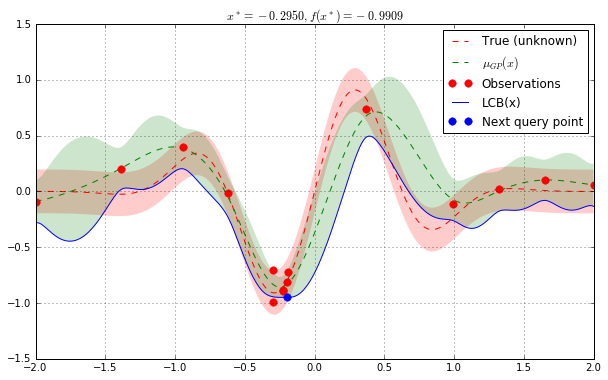

In [8]:
from skopt.acquisition import gaussian_lcb

# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

# Plot GP(x) + concours
gp = res.models[-1]
y_pred, sigma = gp.predict(x, return_std=True)

plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, 
                         (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc="g", ec="None")

# Plot sampled points
plt.plot(res.x_iters, 
         res.func_vals, 
         "r.", markersize=15, label="Observations")

# Plot LCB(x) + next query point
acq = gaussian_lcb(x, gp)
plt.plot(x, gaussian_lcb(x, gp), "b", label="LCB(x)")
next_x = np.argmin(acq)
plt.plot([x[next_x]], [acq[next_x]], "b.", markersize=15, label="Next query point")

plt.title(r"$x^* = %.4f, f(x^*) = %.4f$" % (res.x[0], res.fun))
plt.legend(loc="best")
plt.grid()

plt.show()